# 10.  Use transfer learning for large image classification

_Exercise: Use transfer learning for large image classification, going through these steps:_

* _Create a training set containing at least 100 images per class. For example, you could classify your own pictures based on the location (beach, mountain, city, etc.), or alternatively you can use an existing dataset (e.g., from TensorFlow Datasets)._
* _Split it into a training set, a validation set, and a test set._
* _Build the input pipeline, including the appropriate preprocessing operations, and optionally add data augmentation._
* _Fine-tune a pretrained model on this dataset._

In [1]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

2025-02-26 21:38:39.191693: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740602319.211944  205571 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740602319.219912  205571 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-26 21:38:39.241632: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


1 Physical GPUs, 1 Logical GPUs


I0000 00:00:1740602322.624518  205571 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2874 MB memory:  -> device: 0, name: Quadro P600, pci bus id: 0000:01:00.0, compute capability: 6.1


In [2]:
import tensorflow_datasets as tfds

from keras.api.layers import Conv2D, MaxPooling2D, InputLayer, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.api.models import Sequential, Model
# from keras.api.applications.xception import Xception, preprocess_input
from keras.api.applications.mobilenet import MobileNet, preprocess_input
from keras.api.optimizers import SGD, Nadam
from keras.api.optimizers.schedules import CosineDecayRestarts
from keras.api.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, LearningRateScheduler
from keras.api import layers
from keras.api.regularizers import l2

import collections

import numpy as np

import matplotlib.pyplot as plt

import datetime

In [3]:
ds, info = tfds.load(
    "beans",
    split=["train", "validation", "test"],
    with_info=True,
    shuffle_files=True,
    as_supervised=True,
)

In [4]:
n_classes = info.features["label"].num_classes
class_names = info.features["label"].names

In [5]:
ds_train = ds[0]
ds_valid = ds[1]
ds_test = ds[2]

In [6]:
print(len(list(ds_train)))
print(len(list(ds_valid)))
print(len(list(ds_test)))

2025-02-26 21:38:43.511048: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-02-26 21:38:44.037333: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-26 21:38:44.161296: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1034
133
128


In [7]:
info.description

'Beans is a dataset of images of beans taken in the field using smartphone\ncameras. It consists of 3 classes: 2 disease classes and the healthy class.\nDiseases depicted include Angular Leaf Spot and Bean Rust. Data was annotated by\nexperts from the National Crops Resources Research Institute (NaCRRI) in Uganda\nand collected by the Makerere AI research lab.'

In [8]:
ds_train

<_PrefetchDataset element_spec=(TensorSpec(shape=(500, 500, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [9]:
for image, label in ds_train.take(1):
  print(image.shape, label)

(500, 500, 3) tf.Tensor(1, shape=(), dtype=int64)


2025-02-26 21:38:44.354982: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [10]:
def count_labels(dataset):
    label_counts = collections.Counter()

    for _, label in dataset:
        label_counts[label.numpy()] += 1

    total_count = sum(label_counts.values())
    label_ratios = {label: count / total_count for label, count in label_counts.items()}
    
    sorted_label_ratios = dict(sorted(label_ratios.items()))

    return sorted_label_ratios

In [11]:
# Make sure that ratio of different classes is same across datasets

print(count_labels(ds_train))
print(count_labels(ds_valid))
print(count_labels(ds_test))

{0: 0.33365570599613154, 1: 0.3365570599613153, 2: 0.32978723404255317}
{0: 0.3308270676691729, 1: 0.3383458646616541, 2: 0.3308270676691729}
{0: 0.3359375, 1: 0.3359375, 2: 0.328125}


In [12]:
batch_size = 32
preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True),
    tf.keras.layers.Lambda(preprocess_input)
])

preprocess_and_augmentation = tf.keras.Sequential([
    layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True),
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(factor=(-0.2, 0.2)),  # Reduced rotation
    layers.RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)),  # Reduced zoom
    layers.RandomTranslation(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)),  # Reduced translation
    layers.RandomContrast(factor=0.2),  # Reduced contrast
    layers.RandomBrightness(factor=(-0.2, 0.2)),  # Reduced brightness
    layers.GaussianNoise(stddev=0.05),  # Reduced noise
    layers.Lambda(preprocess_input)
])

In [13]:
ds_train = ds_train.map(
    lambda X, y: (preprocess_and_augmentation(X), y), num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(info.splits['train'].num_examples)
ds_train = ds_train.batch(batch_size)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

In [14]:
ds_valid = ds_valid.map(
    lambda X, y: (preprocess(X), y), num_parallel_calls=tf.data.AUTOTUNE)
ds_valid = ds_valid.cache()
ds_valid = ds_valid.batch(batch_size)
ds_valid = ds_valid.prefetch(tf.data.AUTOTUNE)

In [15]:
ds_test = ds_test.map(
    lambda X, y: (preprocess(X), y), num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.cache()
ds_test = ds_test.batch(batch_size)
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

In [16]:
for image, label in ds_train.take(1):
  print(image)

tf.Tensor(
[[[[-0.6700556  -0.9320078  -0.9636587 ]
   [-0.6559477  -0.9066086  -0.9336989 ]
   [-0.67302525 -0.9171766  -0.94728625]
   ...
   [-0.13537258  0.02798009 -0.5977348 ]
   [-0.14843339  0.00168359 -0.61434686]
   [-0.16490567 -0.01281279 -0.636285  ]]

  [[-0.6285829  -0.8901241  -0.93247163]
   [-0.6322141  -0.8806569  -0.92702603]
   [-0.671396   -0.91417676 -0.9580469 ]
   ...
   [-0.12697941  0.02924395 -0.56226873]
   [-0.09559953  0.04914343 -0.5399008 ]
   [-0.0851655   0.06016159 -0.53624654]]

  [[-0.611976   -0.86807704 -0.91522425]
   [-0.652668   -0.89315236 -0.94483805]
   [-0.68184525 -0.9192049  -0.9677863 ]
   ...
   [-0.1415866   0.01356459 -0.56433415]
   [-0.1001271   0.04435527 -0.5389381 ]
   [-0.09327155  0.05458677 -0.5434334 ]]

  ...

  [[-0.34428734  0.11680114 -0.40931737]
   [-0.32787108  0.13348079 -0.38775212]
   [-0.31309402  0.1453886  -0.37448347]
   ...
   [-0.6606112  -0.73402536 -0.80979705]
   [-0.6900219  -0.8270232  -0.8623248 ]
   [-

2025-02-26 21:38:49.502685: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


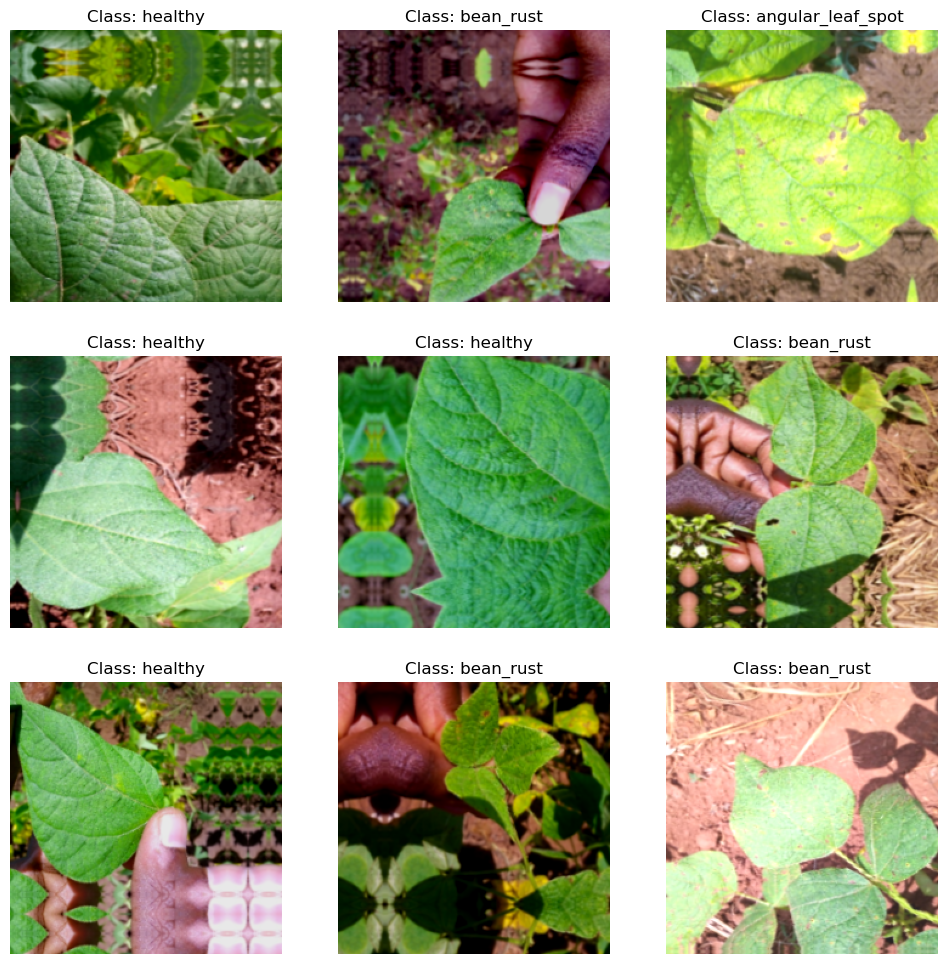

In [17]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in ds_train.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow((X_batch[index] + 1) / 2)  # rescale to 0–1 for imshow()
        plt.title(f"Class: {class_names[y_batch[index]]}")
        plt.axis("off")

plt.show()

In [18]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [19]:
base_model = MobileNet(weights="imagenet", include_top=False)
avg = GlobalAveragePooling2D()(base_model.output)
dropout = Dropout(0.45)(avg)
output = Dense(n_classes, activation="softmax", kernel_regularizer=l2(0.00012))(dropout)
model = Model(inputs=base_model.input, outputs=output)
model.summary()

/tmp/ipykernel_205571/3526393136.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights="imagenet", include_top=False)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, None, None, 32) │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, None, None, 32) │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, None, None, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, None, None, 32) │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, None, None, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, None, None, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, None, None, 64) │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, None, None, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, None, None, 64) │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, None, None, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, None, None,     │         8,192 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, None, None,     │           512 │
│ (BatchNormalization)            │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, None, None,     │         1,152 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, None, None,     │           512 │
│ (BatchNormalization)            │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 3,231,939 (12.33 MB)

 Trainable params: 3,210,051 (12.25 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [20]:
for layer in base_model.layers:
    layer.trainable = False

In [21]:
initial_learning_rate = 0.001  # Slightly increased learning rate
lr_schedule = CosineDecayRestarts(
    initial_learning_rate=initial_learning_rate,
    first_decay_steps=10,  # Adjusted steps
    t_mul=2.0,
    m_mul=0.9,
    alpha=0.0001,  # Adjusted minimum lr
)

In [22]:
def one_cycle_scheduler(epoch, lr):
    max_lr = 0.0008 # Reduced max learning rate
    epochs = 100
    if epoch < epochs * 0.4:
        return max_lr * epoch / (epochs * 0.4)
    else:
        return max_lr * (1 + np.cos(np.pi * (epoch - epochs * 0.4) / (epochs * 0.6))) / 2

lr_callback = LearningRateScheduler(one_cycle_scheduler)

In [23]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, mode="min")
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

In [24]:
optimizer = Nadam(learning_rate=0.0008)
model.compile(
    loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
)
history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=100,
    callbacks=[early_stopping, lr_callback],
)

Epoch 1/100


I0000 00:00:1740602334.960815  205650 service.cc:148] XLA service 0x7f18b8002260 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740602334.960880  205650 service.cc:156]   StreamExecutor device (0): Quadro P600, Compute Capability 6.1
2025-02-26 21:38:55.027976: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1740602335.395817  205650 cuda_dnn.cc:529] Loaded cuDNN version 90700
I0000 00:00:1740602344.623001  205650 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


33/33 ━━━━━━━━━━━━━━━━━━━━ 27s 459ms/step - accuracy: 0.3576 - loss: 1.9384 - val_accuracy: 0.4135 - val_loss: 1.2601 - learning_rate: 0.0000e+00
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.3774 - loss: 1.7987 - val_accuracy: 0.4586 - val_loss: 1.1519 - learning_rate: 2.0000e-05
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.3839 - loss: 1.7467 - val_accuracy: 0.4812 - val_loss: 1.0252 - learning_rate: 4.0000e-05
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.3733 - loss: 1.5534 - val_accuracy: 0.5338 - val_loss: 0.9732 - learning_rate: 6.0000e-05
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.4171 - loss: 1.3679 - val_accuracy: 0.5564 - val_loss: 0.9214 - learning_rate: 8.0000e-05
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.4172 - loss: 1.3075 - val_accuracy: 0.6015 - val_loss: 0.8581 - learning_rate: 1.0000e-04
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.45

In [25]:
early_stopping.best_epoch

59

4/4 - 0s - 109ms/step - accuracy: 0.8828 - loss: 0.2841
0.8828125


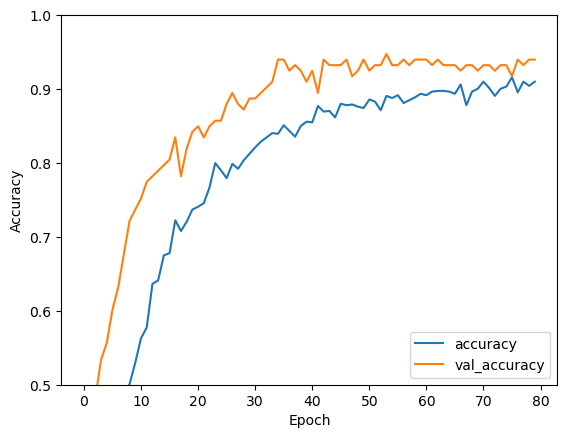

In [26]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(ds_test, verbose=2)
print(test_acc)

In [27]:
len(base_model.layers)

86

In [28]:
# Callbacks (repeating here because EarlyStopping stopped too early second time - better restart it)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, mode="min")
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

In [29]:
# TensorBoard Callback (repeating here to have unique timestamp)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
for layer in base_model.layers[-20:]:
    layer.trainable = True  # Unfreeze the top layers.

optimizer = Nadam(learning_rate=0.000007)
model.compile(
    loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
)
history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=100,
    callbacks=[early_stopping, tensorboard_callback],
)

Epoch 1/100


2025-02-26 21:43:58.310621: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:378] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.
E0000 00:00:1740602639.000777  205648 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1740602639.187428  205648 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1740602639.633571  205648 gpu_timer.cc:8

32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.7445 - loss: 0.6713

2025-02-26 21:44:11.795144: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng18{k11=0} for conv (f32[512,1,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[10,512,14,14]{3,2,1,0}, f32[10,512,14,14]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=512, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-02-26 21:44:11.876179: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.081173249s
Trying algorithm eng18{k11=0} for conv (f32[512,1,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[10,512,14,14]{3,2,1,0}, f32[10,512,14,14]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=512, custom_call_target="__cudnn$convBackward

33/33 ━━━━━━━━━━━━━━━━━━━━ 35s 620ms/step - accuracy: 0.7450 - loss: 0.6696 - val_accuracy: 0.9173 - val_loss: 0.2540
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 228ms/step - accuracy: 0.7722 - loss: 0.5899 - val_accuracy: 0.8947 - val_loss: 0.2980
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 191ms/step - accuracy: 0.8092 - loss: 0.4838 - val_accuracy: 0.9098 - val_loss: 0.3226
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 189ms/step - accuracy: 0.8288 - loss: 0.4527 - val_accuracy: 0.8797 - val_loss: 0.3492
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 202ms/step - accuracy: 0.8691 - loss: 0.3870 - val_accuracy: 0.8947 - val_loss: 0.3250
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 197ms/step - accuracy: 0.8551 - loss: 0.3699 - val_accuracy: 0.9023 - val_loss: 0.3290
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 190ms/step - accuracy: 0.8492 - loss: 0.3521 - val_accuracy: 0.9023 - val_loss: 0.3362
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 190ms/step - accuracy: 0.8754 - loss: 0.3202 - val_accuracy: 0.902

In [31]:
early_stopping.best_epoch

94

4/4 - 0s - 92ms/step - accuracy: 0.9219 - loss: 0.2364
0.921875


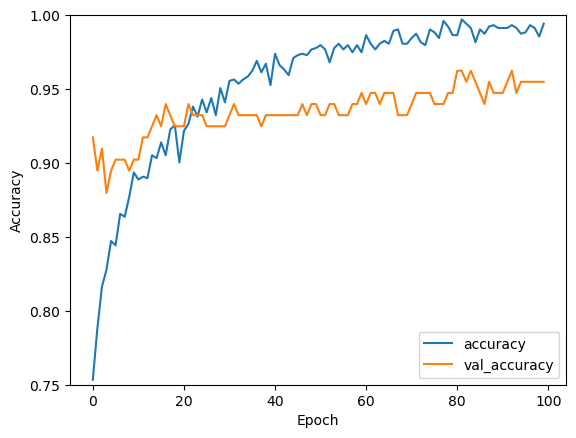

In [32]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.75, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(ds_test, verbose=2)
print(test_acc)

- accuracy without data augmentation or dropout: train: 1.00, validation: 0.9323, test: 0.9062
- accuracy with data augmentation but without dropout: train: 1.00, validation: 0.9549, test: 0.9062
- accuracy with data augmentation and dropout (0.25) : train: 0.9993, validation: 0.9549, test: 0.9453 